### Setup des class et des imports

In [1]:
from src.document_handler.pdf_io import PDFIo
from src.text_extraction.french_text_cleaner import FrenchTextCleaner
from src.document_handler.document_vision import DocumentVision
from src.text_extraction.ocr_text_extractor import OCRTextExtractor
from src.document_classifier.classifier_runner import ONNXDocumentClassifier
from src.trainer.document_classifier_classes import DocumentClassifierClasses

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import StringTensorType, FloatTensorType

import joblib

from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
from onnxruntime import InferenceSession

import numpy as np

In [2]:
io = PDFIo()
doc_vision = DocumentVision()
text_cleaner = FrenchTextCleaner()
text_extractor = OCRTextExtractor(lang="fra+eng")
runner = ONNXDocumentClassifier(onnx_model_path="modeles/clf.onnx", tfidf_model_path="modeles/tfidf.pkl")

## 1 - Ouvrir et extraire les pages d'un PDF

Page 1


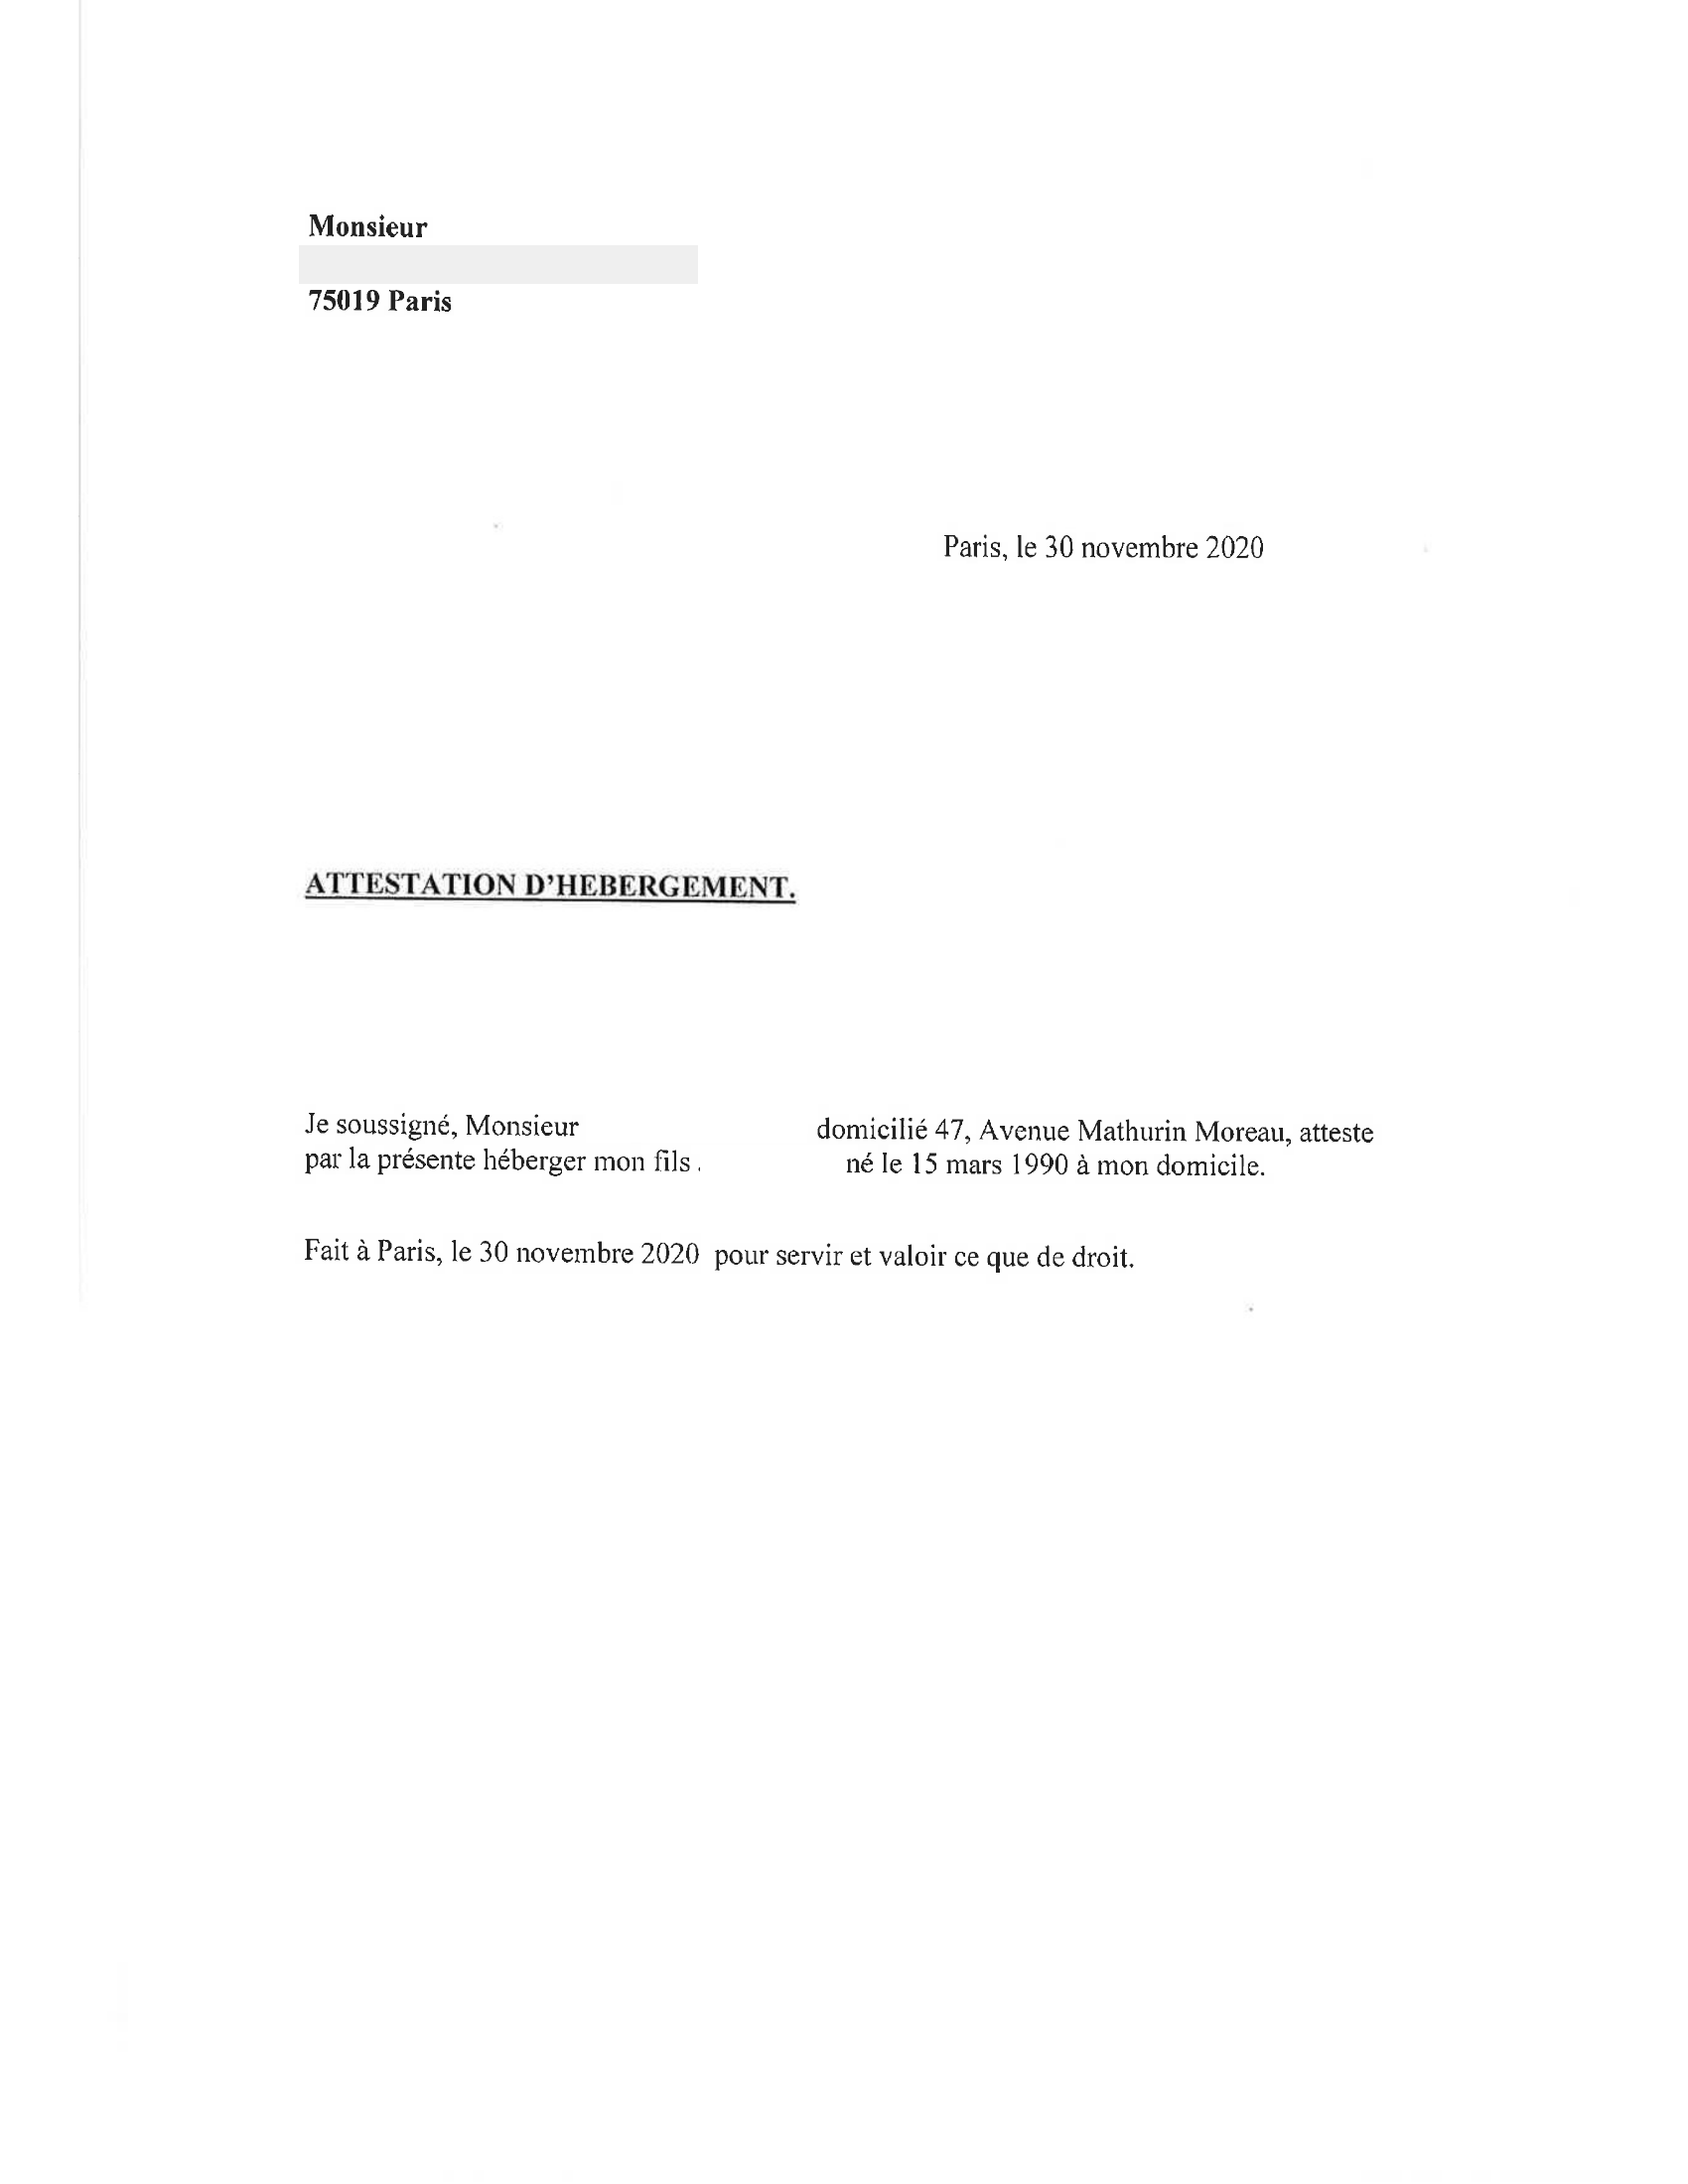

In [4]:
document_path = 'CNAM/5.pdf'

pages = io.load_pages(document_path, auto_rotate=True)
doc_vision.display_page(np.array(pages[0]), title=f"Page 1")

### 3 - Extraire les textes des pages

In [5]:
result_txt = text_extractor.image_to_text(pages[0])
cleaned_text = text_cleaner.clean_text(result_txt)

In [6]:
cleaned_text

'monsieur paris paris novembre attestation hébergement soussigné monsieur domicile avenue morceau atteste présente héberger fils mars domicile fait paris novembre servir valoir droit'

### Analyse du jeu de données

Premièrement, une rapide analyse des types de documents présents dans le jeu de données est nécessaire. Voici les types de documents que nous allons rencontrer :

Types de documents :
- attestation hébergement
- impot taxe foncier
- impot sur revenus
- bulletin de salaire
- releve de compte bancaire

J'ai ensuite renommé les fichiers PDF de 1 à 28 pour faciliter la manipulation et j'ai créée la liste associative ci-dessous pour associer les noms de fichiers aux types de documents.

In [7]:
documents_associations = {
    1 : DocumentClassifierClasses.ATTESTATION_HEBERGEMENT.value,
    2 : DocumentClassifierClasses.ATTESTATION_HEBERGEMENT.value,
    3 : DocumentClassifierClasses.ATTESTATION_HEBERGEMENT.value,
    4 : DocumentClassifierClasses.ATTESTATION_HEBERGEMENT.value,
    5 : DocumentClassifierClasses.ATTESTATION_HEBERGEMENT.value,
    6 : DocumentClassifierClasses.ATTESTATION_HEBERGEMENT.value,
    7: DocumentClassifierClasses.AVIS_IMPOT_TAXE_FONCIERE.value,
    8: DocumentClassifierClasses.AVIS_IMPOT_TAXE_FONCIERE.value,
    9: DocumentClassifierClasses.AVIS_IMPOT_TAXE_FONCIERE.value,
    10: DocumentClassifierClasses.AVIS_IMPOT_TAXE_FONCIERE.value,
    11: DocumentClassifierClasses.AVIS_IMPOT_TAXE_FONCIERE.value,
    12: DocumentClassifierClasses.AVIS_IMPOT_SUR_REVENUS.value,
    13: DocumentClassifierClasses.AVIS_IMPOT_SUR_REVENUS.value,
    14: DocumentClassifierClasses.AVIS_IMPOT_SUR_REVENUS.value,
    15: DocumentClassifierClasses.AVIS_IMPOT_SUR_REVENUS.value,
    16: DocumentClassifierClasses.AVIS_IMPOT_SUR_REVENUS.value,
    17: DocumentClassifierClasses.AVIS_IMPOT_SUR_REVENUS.value,
    18: DocumentClassifierClasses.AVIS_IMPOT_SUR_REVENUS.value,
    19: DocumentClassifierClasses.AVIS_IMPOT_SUR_REVENUS.value,
    20: DocumentClassifierClasses.AVIS_IMPOT_SUR_REVENUS.value,
    21: DocumentClassifierClasses.AVIS_IMPOT_SUR_REVENUS.value,
    22: DocumentClassifierClasses.AVIS_IMPOT_SUR_REVENUS.value,
    23: DocumentClassifierClasses.AVIS_IMPOT_SUR_REVENUS.value,
    24: DocumentClassifierClasses.BULLETIN_DE_SALAIRE.value,
    25: DocumentClassifierClasses.BULLETIN_DE_SALAIRE.value,
    26: DocumentClassifierClasses.BULLETIN_DE_SALAIRE.value,
    27: DocumentClassifierClasses.RELEVE_DE_COMPTE_BANCAIRE.value,
    28: DocumentClassifierClasses.RELEVE_DE_COMPTE_BANCAIRE.value
}

### Entrainement du modèle

In [10]:
from src.trainer.pre_processor import OCRPreprocessor
import os

In [ ]:
cache_dir = "cache/ocr_cache"
pdf_folder = "CNAM"

In [ ]:
preprocessor = OCRPreprocessor(io, text_extractor, text_cleaner, cache_dir=cache_dir)

In [13]:
X = []
y = []

In [16]:
for doc_id, label in documents_associations.items():
    pdf_path = os.path.join(pdf_folder, f"{doc_id}.pdf")
    cleaned_text = preprocessor.preprocess_and_cache(doc_id, pdf_path)
    X.append(cleaned_text)
    y.append(label)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_df=0.85)),
    ('clf', MLPClassifier(hidden_layer_sizes=(128,), max_iter=500, random_state=42))
])

In [19]:
pipeline.fit(X_train, y_train)

,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [20]:
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

                          precision    recall  f1-score   support

 attestation hebergement       1.00      1.00      1.00         1
avis impot taxe fonciere       1.00      1.00      1.00         2
        avis sur revenus       1.00      1.00      1.00         2
     bulletin de salaire       1.00      1.00      1.00         1

                accuracy                           1.00         6
               macro avg       1.00      1.00      1.00         6
            weighted avg       1.00      1.00      1.00         6



### Sauvegarde du modèle et du TF IDF

In [26]:
tfidf = pipeline.named_steps['tfidf']
clf = pipeline.named_steps['clf']
joblib.dump(tfidf, "modeles/tfidf.pkl")

['modeles/tfidf.pkl']

In [28]:
initial_type = [('input', FloatTensorType([None, tfidf.transform(["test"]).shape[1]]))]

onnx_model = convert_sklearn(clf, initial_types=initial_type)

model_folder_dir = "modeles"
modele_path = os.path.join(model_folder_dir, "document_classifier.onnx")
if not os.path.exists(model_folder_dir):
    os.makedirs(model_folder_dir)


with open(modele_path, "wb") as f:
    f.write(onnx_model.SerializeToString())

### Test d'une inférence

In [ ]:
prediction = runner.predict([cleaned_text])
print("Prédiction ONNX :", prediction[0])